### Планирование эксперимента

In [99]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

%matplotlib inline

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [58]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [59]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [60]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [61]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [62]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [63]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [66]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [67]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [68]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [69]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [70]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [71]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [72]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:
precision - отношение объектов, которые алгоритм назвал положительными и они действительно положительны, ко всем объектам, которые алгоритм назвал положительными
recall - доля объектов положительного класса, которую нашел алгоритм
1. обе метрики в числители имеют TP, а в знаменателе TP + FP или FN. Cоответственно, порог вероятности определяет к какому классу будет отнесен объект, поэтому количество TP /FP / FN  может измениться в зависимости от порога, а значит и метрики
2. вцелом подобрать порог, чтобы recall был 1 возможно(FN должен быть равен 0), тогда значение precision будет зависеть от значения FP
3. аналогично с п 2. значение recall будет зависеть от значения FN

Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


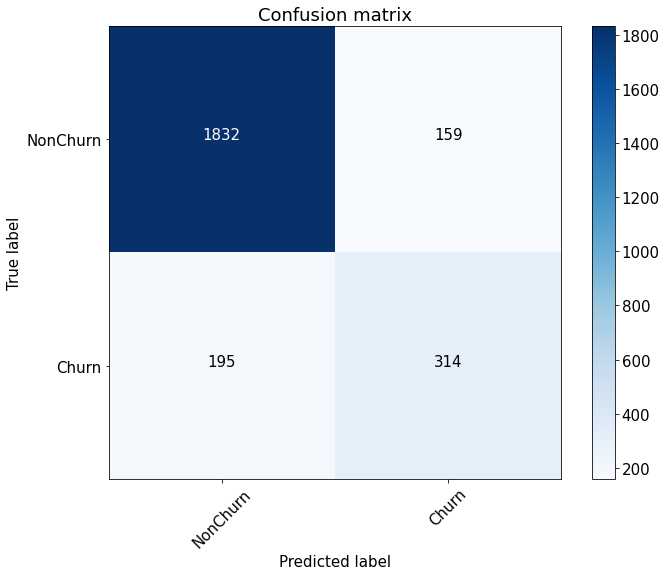

In [73]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

In [146]:
#удерживаем только тех кто по модели уйдет в отток
# затраты на удержание(по модели)
zatr = 159+314
prib = 195*2
diff = prib - zatr
print(zatr, prib, diff)

473 390 -83


Таким образом, модель не является потенциально экономически целесообразной. Затраты на удержание больше прибыли от удержанных клиентов

# XGBoost

In [76]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [77]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [78]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.
Добавим модель

In [79]:
pipeline2 = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42)),
])

In [80]:
#обучим модель
#обучим наш пайплайн
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [81]:
#наши прогнозы для тестовой выборки
preds = pipeline2.predict_proba(X_test)[:, 1]
preds[:10]

array([0.47611395, 0.23087966, 0.07372608, 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [82]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [83]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


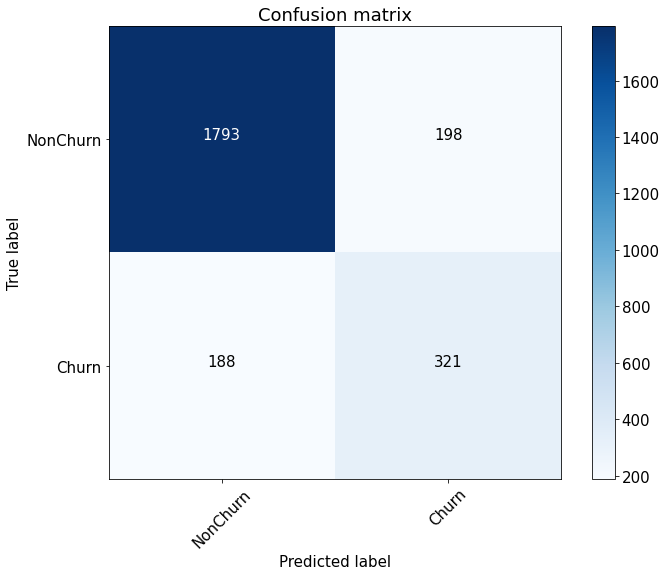

In [84]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [147]:
# затраты на удержание(по модели)
zatr = 198+321
prib = 188*2
diff = prib - zatr
print(zatr, prib, diff)

519 376 -143


Таким образом, модель является потенциально экономически не целесообразной. 

# LogisticRegression

In [87]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [88]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [89]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [90]:
pipeline3 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [91]:
#обучим модель
#обучим наш пайплайн
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [92]:
#наши прогнозы для тестовой выборки
preds = pipeline3.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [93]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [94]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


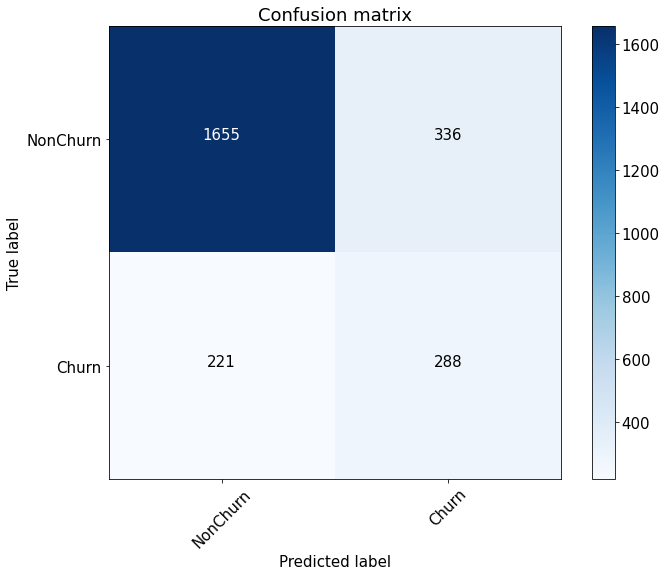

In [95]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [148]:
zatr = 288+336
prib = 221*2
diff = prib - zatr
print(zatr, prib, diff)

624 442 -182


Таким образом, модель является потенциально экономически не целесообразной. 

Лес
Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629
-83

XGBoost
Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633
-143

LogisticRegression
Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568

-182



Лучшая модель по метрикам(f1 и Precision) получилась случайный лес. 
Если смотреть по экономическим показателям - то ближайщий прогноз по прибыли получился в случайном лесе
Таким образом, лучшая метрика - Precision

# Подбор гиперпараметров для XGBoost

- Grid Search из sklearn
- Randomized Search
- Байесовская оптимизация
 hyperopt – популярной python-библиотеки для подбора гиперпарметров. В ней реализовано 3 алгоритма оптимизации: классический Random Search, метод байесовской оптимизации Tree of Parzen Estimators (TPE), и Simulated Annealing – ещё одна версия Random Search. Hyperopt может работать с разными типами гиперпараметров –непрерывными, дискретными, категориальными и т.д, что является важным преимуществом этой библиотеки.

In [98]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])


pipeline4 = Pipeline([
    ('features',feats)
])
pipeline4.fit(X_train)
X_train_new = pipeline4.transform(X_train)
X_test_new = pipeline4.transform(X_test)

In [114]:
def objective(space):

    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            random_state = 42
                            )
    
    classifier.fit(X_train_new, y_train)

    # Applying k-Fold Cross Validation
    
    accuracies = cross_val_score(estimator = classifier, X = X_train_new, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(1, 100, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 1, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(5, 500, 5)),
    'gamma' : hp.quniform('gamma', 0, 1, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)



CrossValMean:                                         
0.8354666666666667                                    
CrossValMean:                                                                   
0.8590666666666668                                                              
CrossValMean:                                                                    
0.8354666666666667                                                               
CrossValMean:                                                                    
0.8588000000000001                                                               
CrossValMean:                                                                    
0.8550666666666666                                                               
CrossValMean:                                                                    
0.7816000000000001                                                               
CrossValMean:                                                           

In [115]:
best

{'colsample_bytree': 0.43,
 'gamma': 0.08,
 'learning_rate': 0.02,
 'max_depth': 94,
 'min_child_weight': 14.0,
 'n_estimators': 96,
 'subsample': 0.99}

In [131]:
pipeline5 = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(n_estimators = 96,
                            max_depth = 94,
                            learning_rate = 0.02,
                            gamma = 0.08,
                            min_child_weight = 14.0,
                            subsample = 0.99,
                            colsample_bytree = 0.43,
                                     random_state = 42 )),
])
pipeline5.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [133]:
#наши прогнозы для тестовой выборки
preds = pipeline5.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380092, F-Score=0.641, Precision=0.700, Recall=0.591


Confusion matrix, without normalization
[[1862  129]
 [ 209  300]]


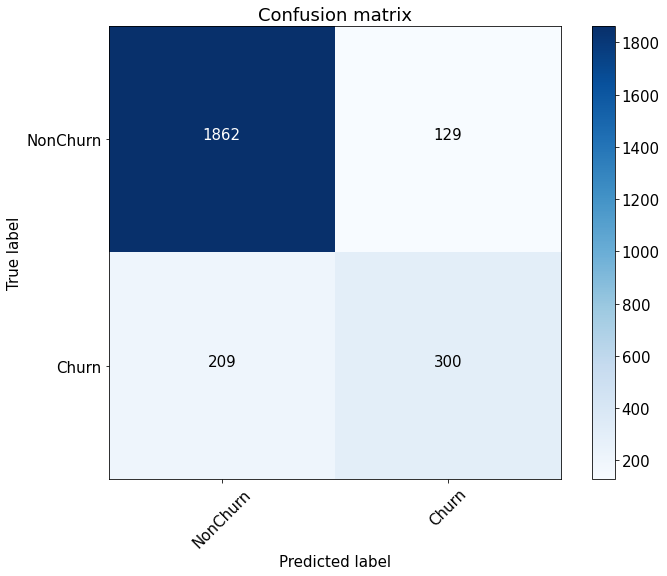

In [134]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [149]:
#удерживаем только тех кто по модели уйдет в отток
# затраты на удержание(по модели)
zatr = 300+129
prib = 209*2
diff = prib - zatr
print(zatr, prib, diff)

429 418 -11


# подбор гиперпараметров для RandomForestClassifier

In [124]:
def objective(space):

    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = RandomForestClassifier (n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            max_features = space['max_features'],
                            criterion = space['criterion'] ,
                                         random_state = 42
            
                            )
    
    classifier.fit(X_train_new, y_train)

    # Applying k-Fold Cross Validation
    
    accuracies = cross_val_score(estimator = classifier, X = X_train_new, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }


space = {
    'max_depth': hp.choice('max_depth', range(1,100)),
    'max_features': hp.choice('max_features', range(1,25)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)


CrossValMean:                                         
0.7962666666666667                                    
CrossValMean:                                                                    
0.8564                                                                           
CrossValMean:                                                                    
0.8538666666666666                                                               
CrossValMean:                                                                    
0.8574666666666667                                                               
CrossValMean:                                                                    
0.8450666666666666                                                              
CrossValMean:                                                                   
0.8563999999999998                                                              
CrossValMean:                                                            

In [127]:
pipeline6 = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators = 278,
                            max_depth = 88,
                            max_features = 5,
                            criterion = "entropy" ,
                                         random_state = 42 )),
])
pipeline6.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [128]:
#наши прогнозы для тестовой выборки
preds = pipeline6.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.356115, F-Score=0.646, Precision=0.643, Recall=0.650


Confusion matrix, without normalization
[[1811  180]
 [ 185  324]]


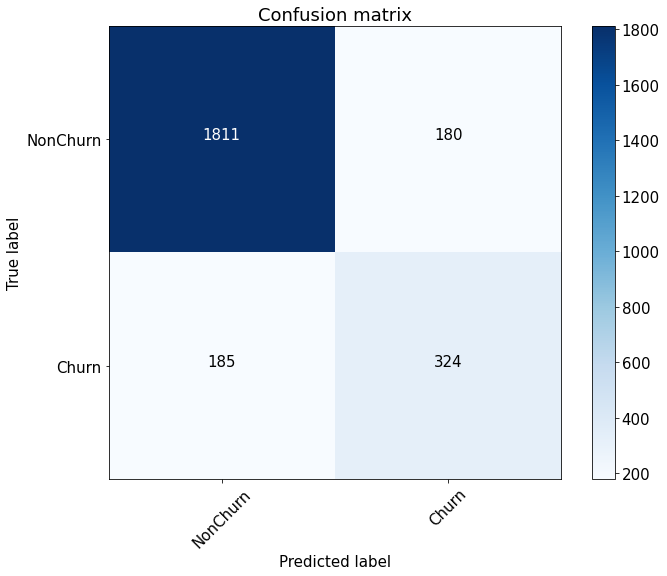

In [129]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [150]:
#удерживаем только тех кто по модели уйдет в отток
# затраты на удержание(по модели)
zatr = 324+180
prib = 185*2
diff = prib - zatr
print(zatr, prib, diff)

504 370 -134


Таким образом получаются следующие результаты(упорядочим по увеличению разницы прибыли )

по гиперпараметрам бустинг
Best Threshold=0.380092, F-Score=0.641, Precision=0.700, Recall=0.591
 -11

лес
Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629
-83



лес гиперпараметры
Best Threshold=0.356115, F-Score=0.646, Precision=0.643, Recall=0.650
-134

бустинг
Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633
-143



линейная регрессия
Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
 -182


По полученным результатам, видим что:
- если брать логику рассчета экономической эффективности как в этой задаче,  то лучшая метрика получается precision



### Домашнее задание

1. Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/list/stat.ML/recent